# Sentiment Analysis on Movie Reviews
Using multiple architectures to perform sentiment analysis on the IMDB dataset. The dataset consists of 50,000 reviews from IMDB, labeled by sentiment (positive/negative). The dataset is divided into 25,000 reviews for training and 25,000 reviews for testing. The goal is to build a model that can predict the sentiment of a review with high accuracy.

The following architectures will be used:
1. RNN
2. LSTM
3. GRU
4. Bidirectional RNN
5. Bidirectional LSTM
6. Bidirectional GRU
7. Convolutional Neural Network (CNN)

The models will be trained on the training set and evaluated on the testing set. The model with the highest accuracy on the testing set will be selected as the best model for sentiment analysis on movie reviews.

In [1]:
import torch
import string
import pandas as pd
from collections import Counter

from model import SentimentAnalyzer
from utils import EarlyStopping, Utils

from datasets import load_dataset
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download and load the IMDb dataset
dataset = load_dataset('imdb')

In [2]:
# convert DatasetDict to a pandas dataframe
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])

print(df_train.shape, df_test.shape)
df_train.head(3)

(25000, 2) (25000, 2)


,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0


<Axes: title={'center': 'Label Distribution'}, xlabel='label'>

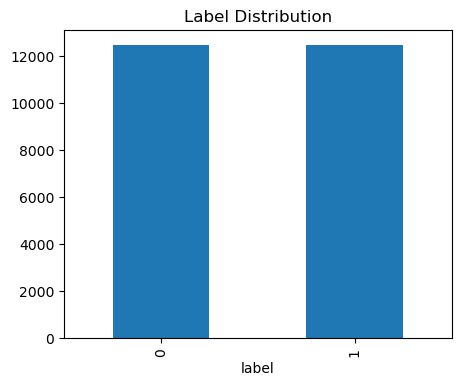

In [3]:
# Check label distribution
df_train['label'].value_counts().plot(kind='bar', title='Label Distribution', figsize=(5, 4))

# Preprocessing and Tokenization

In [4]:
# Tokenize the reviews (NLTK tokenizer)
df_train['text'] = df_train['text'].apply(word_tokenize)
df_test['text'] = df_test['text'].apply(word_tokenize)

# Lowercase the reviews
df_train['text'] = df_train['text'].apply(lambda x: [s.lower() for s in x])
df_test['text'] = df_test['text'].apply(lambda x: [s.lower() for s in x])

# Remove html tags
tags = ['<', '>', 'br', '/', '``', "''", '...']
df_train['text'] = df_train['text'].apply(lambda x: [s for s in x if not s.startswith('<') and not s.endswith('>') and s not in tags])
df_test['text'] = df_test['text'].apply(lambda x: [s for s in x if not s.startswith('<') and not s.endswith('>') and s not in tags])

# Remove punctuation like '!', '?', etc.
df_train['text'] = df_train['text'].apply(lambda x: [s for s in x if s not in string.punctuation])
df_test['text'] = df_test['text'].apply(lambda x: [s for s in x if s not in string.punctuation])

# Remove stopwords like 'and', 'the', 'a', etc.
stop_words = set(stopwords.words('english'))
df_train['text'] = df_train['text'].apply(lambda x: [s for s in x if s not in stop_words])
df_test['text'] = df_test['text'].apply(lambda x: [s for s in x if s not in stop_words])

# Remove numbers
df_train['text'] = df_train['text'].apply(lambda x: [s for s in x if not s.isdigit()])
df_test['text'] = df_test['text'].apply(lambda x: [s for s in x if not s.isdigit()])

# Remove empty strings
df_train['text'] = df_train['text'].apply(lambda x: [s for s in x if s])
df_test['text'] = df_test['text'].apply(lambda x: [s for s in x if s])

# Add 10K rows to the training set from the test set
df_train = pd.concat([df_train, df_test.sample(10000, random_state=0)]).reset_index(drop=True)

# Shuffle the dataset
df_train = df_train.sample(frac=1, random_state=0).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=0).reset_index(drop=True)

# Get the max/min length of the reviews
max_len = df_train['text'].apply(len).max()
min_len = df_train['text'].apply(len).min()
avg_len = df_train['text'].apply(len).mean().round()

print(f'Max length: {max_len}, Min length: {min_len}, Avg length: {avg_len}')

# Quick look at the preprocessed data
display(df_train.head(3))

df_train.shape, df_test.shape

Max length: 1450, Min length: 4, Avg length: 123.0


,text,label
0,"[far, racist, ghettoish, cartoon, children, 7+...",0
1,"[one, worst, movies, 've, ever, seen, 'm, stil...",0
2,"[thin, story, many, fine, shots, eyecatchers, ...",1


((35000, 2), (25000, 2))

# Vocabulary Creation
vocab creation is the first step in the text processing pipeline. It is the process of extracting unique words from the text and assigning an index to each word. The vocabulary is used to convert the text into a numerical representation that can be used as input to machine learning models.

In [5]:
# Copy for future use
df_train_preprocessed, df_test_preprocessed = df_train.copy(), df_test.copy()

In [6]:
# Create a vocabulary
vocab = set()
for review in df_train['text']:
    vocab.update(review)
for review in df_test['text']:
    vocab.update(review)

print('Vocab Size:', len(list(vocab)))

Vocab Size: 162974


Since the vocabulary is huge, we will only keep the most 20K frequent words, after that we will replace the rest with `<UNK>`

In [7]:
word_freq = Counter()

for review in df_train['text']:
    word_freq.update(review)
for review in df_test['text']:
    word_freq.update(review)

# Create a vocabulary
vocab = ['<PAD>', '<UNK>'] + [word for word, _ in word_freq.most_common(20_000)] # <PAD> is for padding to tell the embedding layer to ignore it, <UNK> is for unknown words

print(len(vocab))

20002


Convert the text into sequences of integers using the vocabulary. Each token in the text is replaced by its corresponding index in the vocabulary.

In [8]:
max_len = 300 # Maximum length of tokens in a review (context window)

# Create a word to index mapping
word_to_idx = {word: idx for idx, word in enumerate(vocab)}

# Convert the reviews to indices
df_train['text'] = df_train['text'].apply(lambda x: [word_to_idx.get(word, 1) for word in x]) # 1 is the index of '<UNK>' token
df_test['text'] = df_test['text'].apply(lambda x: [word_to_idx.get(word, 1) for word in x])

# Truncate and pad the reviews
df_train['text'] = df_train['text'].apply(lambda x: x[:max_len] if len(x) > max_len else x + [0] * (max_len - len(x))) # Pad with zeros as the index of '<PAD>' is 0
df_test['text'] = df_test['text'].apply(lambda x: x[:max_len] if len(x) > max_len else x + [0] * (max_len - len(x)))

# print the first 3 reviews
display(df_train.head(3), df_train_preprocessed.head(3))

# Split test set into validation and test sets
df_val = df_test.sample(frac=0.5)
df_test = df_test.drop(df_val.index)

# Convert data to lists
X_train, y_train = df_train['text'].tolist(), df_train['label'].tolist()
X_val, y_val = df_val['text'].tolist(), df_val['label'].tolist()
X_test, y_test = df_test['text'].tolist(), df_test['label'].tolist()

,text,label
0,"[126, 2651, 1, 923, 295, 1, 228, 30, 923, 1089...",0
1,"[6, 141, 27, 54, 45, 34, 57, 48, 142, 453, 193...",0
2,"[1611, 14, 33, 366, 514, 1, 175, 1925, 1, 587,...",1


,text,label
0,"[far, racist, ghettoish, cartoon, children, 7+...",0
1,"[one, worst, movies, 've, ever, seen, 'm, stil...",0
2,"[thin, story, many, fine, shots, eyecatchers, ...",1


# RNN Model (Unidirectional)

In [9]:
# Same Parameters for all models
embedding_dim = 128
hidden_dim = 256
dropout = 0.3
n_layers = 2
lr = 1e-3

model_rnn = SentimentAnalyzer(model_type='rnn',
                            vocab_size=len(vocab),
                            embedding_dim=embedding_dim,
                            hidden_dim=hidden_dim,
                            bidirectional=False,
                            dropout=dropout,
                            pad_idx=0,
                            n_layers=n_layers,
                            lr=lr,
                            verbose=True,
                            gpu=True)

early_stopping = EarlyStopping(patience=5, delta=0.01, path='weights/rnn.pth') # early stops after 3 consecutive epochs with minor loss decrease/increase
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_rnn.optimizer, mode='min', factor=0.1, patience=2) # reduces learning rate by factor of 0.1 when no improvement is seen

SentimentAnalyzer(
  (embedding): Embedding(20002, 128, padding_idx=0)
  (rnn): RNN(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): BCELoss()
) 
Running on:  cuda
Number of parameters: 2,790,913


In [10]:
history_rnn = model_rnn.fit(X_train,
                        y_train,
                        epochs=10,
                        batch_size=128,
                        val_data=(X_val, y_val),
                        early_stopping=early_stopping,
                        scheduler=scheduler
                        )

Epoch 1/10 - Train Loss: 0.7336 - Val Loss: 0.7141 - Acc: 0.4954 - F1: 0.6307 - Precision: 0.4941 - Recall: 0.8718 - lr: 0.001


Epoch 2/10 - Train Loss: 0.7058 - Val Loss: 0.6938 - Acc: 0.5052 - F1: 0.0698 - Precision: 0.4936 - Recall: 0.0375 - lr: 0.001


Epoch 3/10 - Train Loss: 0.6961 - Val Loss: 0.6939 - Acc: 0.4982 - F1: 0.1890 - Precision: 0.4701 - Recall: 0.1183 - lr: 0.001


Epoch 4/10 - Train Loss: 0.6959 - Val Loss: 0.6937 - Acc: 0.4982 - F1: 0.1869 - Precision: 0.4694 - Recall: 0.1167 - lr: 0.001


Epoch 5/10 - Train Loss: 0.6960 - Val Loss: 0.6941 - Acc: 0.4981 - F1: 0.1837 - Precision: 0.4685 - Recall: 0.1143 - lr: 0.0001


Epoch 6/10 - Train Loss: 0.6935 - Val Loss: 0.6932 - Acc: 0.5057 - F1: 0.0000 - Precision: 0.0000 - Recall: 0.0000 - lr: 0.0001


Epoch 7/10 - Train Loss: 0.6934 - Val Loss: 0.6932 - Acc: 0.5051 - F1: 0.0675 - Precision: 0.4923 - Recall: 0.0363 - lr: 0.0001
Early stopping...


In [11]:
# evaluate the model
loss, acc, f1, precision, recall = model_rnn.evaluate((X_test, y_test), batch_size=256)
print(f'Loss: {loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

Loss: 0.6933, Accuracy: 0.4957, F1: 0.0658, Precision: 0.5199, Recall: 0.0351


# RNN Model (Bidirectional)

In [12]:
model_rnn_bi = SentimentAnalyzer(model_type='rnn',
                            vocab_size=len(vocab),
                            embedding_dim=embedding_dim,
                            hidden_dim=hidden_dim,
                            bidirectional=True, # Bidirectional RNN
                            dropout=dropout,
                            pad_idx=0,
                            n_layers=n_layers,
                            lr=lr,
                            verbose=True,
                            gpu=True)

early_stopping = EarlyStopping(patience=5, delta=0.01, path='weights/rnn_bi.pth') # early stops after 3 consecutive epochs with minor loss decrease/increase
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_rnn_bi.optimizer, mode='min', factor=0.1, patience=5) # reduces learning rate by factor of 0.1 when no improvement is seen

SentimentAnalyzer(
  (embedding): Embedding(20002, 128, padding_idx=0)
  (rnn): RNN(128, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): BCELoss()
) 
Running on:  cuda
Number of parameters: 3,152,641


In [13]:
# Train the model
history_rnn_bi = model_rnn_bi.fit(X_train,
                        y_train,
                        epochs=10,
                        batch_size=256,
                        val_data=(X_val, y_val),
                        early_stopping=early_stopping,
                        scheduler=scheduler
                        )

Epoch 1/10:   0%|          | 0/137 [00:00<?, ?batch/s]

Epoch 1/10 - Train Loss: 0.7364 - Val Loss: 0.6347 - Acc: 0.6389 - F1: 0.6248 - Precision: 0.6422 - Recall: 0.6084 - lr: 0.001


Epoch 2/10 - Train Loss: 0.5868 - Val Loss: 0.5168 - Acc: 0.7542 - F1: 0.7477 - Precision: 0.7587 - Recall: 0.7370 - lr: 0.001


Epoch 3/10 - Train Loss: 0.5067 - Val Loss: 0.5030 - Acc: 0.7566 - F1: 0.7522 - Precision: 0.7573 - Recall: 0.7470 - lr: 0.001


Epoch 4/10 - Train Loss: 0.4068 - Val Loss: 0.4332 - Acc: 0.8136 - F1: 0.8149 - Precision: 0.8003 - Recall: 0.8301 - lr: 0.001


Epoch 5/10 - Train Loss: 0.3531 - Val Loss: 0.3918 - Acc: 0.8453 - F1: 0.8497 - Precision: 0.8174 - Recall: 0.8846 - lr: 0.001


Epoch 6/10 - Train Loss: 0.2520 - Val Loss: 0.3783 - Acc: 0.8538 - F1: 0.8501 - Precision: 0.8619 - Recall: 0.8386 - lr: 0.001


Epoch 7/10 - Train Loss: 0.2022 - Val Loss: 0.3685 - Acc: 0.8662 - F1: 0.8696 - Precision: 0.8388 - Recall: 0.9027 - lr: 0.001


Epoch 8/10 - Train Loss: 0.2390 - Val Loss: 0.4785 - Acc: 0.7853 - F1: 0.7915 - Precision: 0.7610 - Recall: 0.8246 - lr: 0.001


Epoch 9/10 - Train Loss: 0.3220 - Val Loss: 0.5559 - Acc: 0.7198 - F1: 0.7189 - Precision: 0.7131 - Recall: 0.7249 - lr: 0.001


Epoch 10/10 - Train Loss: 0.2726 - Val Loss: 0.4281 - Acc: 0.8429 - F1: 0.8410 - Precision: 0.8412 - Recall: 0.8409 - lr: 0.001


# LSTM Model (Unidirectional)

In [14]:
model_lstm = SentimentAnalyzer(model_type='lstm',
                            vocab_size=len(vocab),
                            embedding_dim=embedding_dim,
                            hidden_dim=hidden_dim,
                            bidirectional=False,
                            dropout=dropout,
                            pad_idx=0,
                            n_layers=n_layers,
                            lr=lr,
                            verbose=True,
                            gpu=True)

early_stopping = EarlyStopping(patience=5, delta=0.01, path='weights/lstm.pth') # early stops after 3 consecutive epochs with minor loss decrease/increase
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_lstm.optimizer, mode='min', factor=0.1, patience=2) # reduces learning rate by factor of 0.1 when no improvement is seen

SentimentAnalyzer(
  (embedding): Embedding(20002, 128, padding_idx=0)
  (rnn): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): BCELoss()
) 
Running on:  cuda
Number of parameters: 3,482,113


In [15]:
history_lstm = model_lstm.fit(X_train,
                        y_train,
                        epochs=10,
                        batch_size=128,
                        val_data=(X_val, y_val),
                        early_stopping=early_stopping,
                        scheduler=scheduler
                        )

Epoch 1/10 - Train Loss: 0.6991 - Val Loss: 0.6947 - Acc: 0.4943 - F1: 0.6616 - Precision: 0.4943 - Recall: 1.0000 - lr: 0.001


Epoch 2/10 - Train Loss: 0.6957 - Val Loss: 0.6931 - Acc: 0.5057 - F1: 0.0000 - Precision: 0.0000 - Recall: 0.0000 - lr: 0.001


Epoch 3/10 - Train Loss: 0.6957 - Val Loss: 0.6931 - Acc: 0.5057 - F1: 0.0000 - Precision: 0.0000 - Recall: 0.0000 - lr: 0.001


Epoch 4/10 - Train Loss: 0.6952 - Val Loss: 0.6932 - Acc: 0.4943 - F1: 0.6616 - Precision: 0.4943 - Recall: 1.0000 - lr: 0.001


Epoch 5/10 - Train Loss: 0.6949 - Val Loss: 0.6932 - Acc: 0.4943 - F1: 0.6616 - Precision: 0.4943 - Recall: 1.0000 - lr: 0.0001


Epoch 6/10 - Train Loss: 0.6935 - Val Loss: 0.6931 - Acc: 0.5065 - F1: 0.0090 - Precision: 0.6087 - Recall: 0.0045 - lr: 0.0001
Early stopping...


# LSTM Model (Bidirectional)

In [16]:
model_lstm_bi = SentimentAnalyzer(model_type='lstm',
                            vocab_size=len(vocab),
                            embedding_dim=embedding_dim,
                            hidden_dim=hidden_dim,
                            bidirectional=True, # Bidirectional LSTM
                            dropout=dropout,
                            pad_idx=0,
                            n_layers=n_layers,
                            lr=lr,
                            verbose=True,
                            gpu=True)

early_stopping = EarlyStopping(patience=5, delta=0.01, path='weights/lstm_bi.pth') # early stops after 3 consecutive epochs with minor loss decrease/increase
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_lstm_bi.optimizer, mode='min', factor=0.1, patience=2) # reduces learning rate by factor of 0.1 when no improvement is seen

SentimentAnalyzer(
  (embedding): Embedding(20002, 128, padding_idx=0)
  (rnn): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): BCELoss()
) 
Running on:  cuda
Number of parameters: 4,928,257


In [17]:
history_lstm_bi = model_lstm_bi.fit(X_train,
                        y_train,
                        epochs=10,
                        batch_size=128,
                        val_data=(X_val, y_val),
                        early_stopping=early_stopping,
                        scheduler=scheduler
                        )

Epoch 1/10 - Train Loss: 0.6909 - Val Loss: 0.5429 - Acc: 0.7299 - F1: 0.7514 - Precision: 0.6894 - Recall: 0.8255 - lr: 0.001


Epoch 2/10 - Train Loss: 0.4775 - Val Loss: 0.3149 - Acc: 0.8671 - F1: 0.8641 - Precision: 0.8740 - Recall: 0.8543 - lr: 0.001


Epoch 3/10 - Train Loss: 0.2895 - Val Loss: 0.2532 - Acc: 0.9009 - F1: 0.8995 - Precision: 0.9014 - Recall: 0.8977 - lr: 0.001


Epoch 4/10 - Train Loss: 0.2188 - Val Loss: 0.2486 - Acc: 0.9086 - F1: 0.9053 - Precision: 0.9282 - Recall: 0.8835 - lr: 0.001


Epoch 5/10 - Train Loss: 0.1686 - Val Loss: 0.2329 - Acc: 0.9163 - F1: 0.9148 - Precision: 0.9205 - Recall: 0.9092 - lr: 0.001


Epoch 6/10 - Train Loss: 0.1467 - Val Loss: 0.2541 - Acc: 0.9149 - F1: 0.9158 - Precision: 0.8958 - Recall: 0.9367 - lr: 0.001


Epoch 7/10 - Train Loss: 0.1153 - Val Loss: 0.2714 - Acc: 0.9150 - F1: 0.9129 - Precision: 0.9245 - Recall: 0.9016 - lr: 0.001


Epoch 8/10 - Train Loss: 0.1058 - Val Loss: 0.3042 - Acc: 0.8988 - F1: 0.8920 - Precision: 0.9441 - Recall: 0.8453 - lr: 0.0001


Epoch 9/10 - Train Loss: 0.0632 - Val Loss: 0.2867 - Acc: 0.9188 - F1: 0.9184 - Precision: 0.9123 - Recall: 0.9246 - lr: 0.0001


Epoch 10/10 - Train Loss: 0.0502 - Val Loss: 0.2949 - Acc: 0.9210 - F1: 0.9205 - Precision: 0.9164 - Recall: 0.9246 - lr: 0.0001
Early stopping...


# GRU Model (Unidirectional)

In [18]:
model_gru = SentimentAnalyzer(model_type='gru',
                            vocab_size=len(vocab),
                            embedding_dim=embedding_dim,
                            hidden_dim=hidden_dim,
                            bidirectional=False,
                            dropout=dropout,
                            pad_idx=0,
                            n_layers=n_layers,
                            lr=lr,
                            verbose=True,
                            gpu=True)

early_stopping = EarlyStopping(patience=5, delta=0.01, path='weights/gru.pth') # early stops after 3 consecutive epochs with minor loss decrease/increase
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_gru.optimizer, mode='min', factor=0.1, patience=1) # reduces learning rate by factor of 0.1 when no improvement is seen

SentimentAnalyzer(
  (embedding): Embedding(20002, 128, padding_idx=0)
  (rnn): GRU(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): BCELoss()
) 
Running on:  cuda
Number of parameters: 3,251,713


In [19]:
history_gru = model_gru.fit(X_train,
                        y_train,
                        epochs=10,
                        batch_size=128,
                        val_data=(X_val, y_val),
                        early_stopping=early_stopping,
                        scheduler=scheduler
                        )

Epoch 1/10 - Train Loss: 0.6935 - Val Loss: 0.6920 - Acc: 0.5176 - F1: 0.0954 - Precision: 0.6530 - Recall: 0.0515 - lr: 0.001


Epoch 2/10 - Train Loss: 0.6867 - Val Loss: 0.6859 - Acc: 0.5059 - F1: 0.6623 - Precision: 0.5001 - Recall: 0.9799 - lr: 0.001


Epoch 3/10 - Train Loss: 0.6665 - Val Loss: 0.6923 - Acc: 0.5052 - F1: 0.6618 - Precision: 0.4998 - Recall: 0.9794 - lr: 0.001


Epoch 4/10 - Train Loss: 0.6611 - Val Loss: 0.6970 - Acc: 0.5057 - F1: 0.6619 - Precision: 0.5000 - Recall: 0.9790 - lr: 0.0001


Epoch 5/10 - Train Loss: 0.6552 - Val Loss: 0.6952 - Acc: 0.5226 - F1: 0.0908 - Precision: 0.7740 - Recall: 0.0482 - lr: 0.0001


Epoch 6/10 - Train Loss: 0.6523 - Val Loss: 0.6958 - Acc: 0.5258 - F1: 0.1045 - Precision: 0.7846 - Recall: 0.0560 - lr: 1e-05
Early stopping...


# GRU Model (Bidirectional)

In [20]:
model_gru_bi = SentimentAnalyzer(model_type='gru',
                            vocab_size=len(vocab),
                            embedding_dim=embedding_dim,
                            hidden_dim=hidden_dim,
                            bidirectional=True,
                            dropout=dropout,
                            pad_idx=0,
                            n_layers=n_layers,
                            lr=lr,
                            verbose=True,
                            gpu=True)

early_stopping = EarlyStopping(patience=5, delta=0.01, path='weights/gru_bi.pth') # early stops after 3 consecutive epochs with minor loss decrease/increase
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_gru_bi.optimizer, mode='min', factor=0.1, patience=1) # reduces learning rate by factor of 0.1 when no improvement is seen

SentimentAnalyzer(
  (embedding): Embedding(20002, 128, padding_idx=0)
  (rnn): GRU(128, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): BCELoss()
) 
Running on:  cuda
Number of parameters: 4,336,385


In [21]:
history_gru_bi = model_gru_bi.fit(X_train,
                        y_train,
                        epochs=10,
                        batch_size=128,
                        val_data=(X_val, y_val),
                        early_stopping=early_stopping,
                        scheduler=scheduler
                        )

Epoch 1/10 - Train Loss: 0.4901 - Val Loss: 0.2896 - Acc: 0.8838 - F1: 0.8829 - Precision: 0.8802 - Recall: 0.8856 - lr: 0.001


Epoch 2/10 - Train Loss: 0.2443 - Val Loss: 0.2262 - Acc: 0.9146 - F1: 0.9164 - Precision: 0.8882 - Recall: 0.9464 - lr: 0.001


Epoch 3/10 - Train Loss: 0.1630 - Val Loss: 0.2300 - Acc: 0.9166 - F1: 0.9163 - Precision: 0.9101 - Recall: 0.9225 - lr: 0.001


Epoch 4/10 - Train Loss: 0.1247 - Val Loss: 0.2599 - Acc: 0.9185 - F1: 0.9174 - Precision: 0.9188 - Recall: 0.9160 - lr: 0.0001


Epoch 5/10 - Train Loss: 0.0745 - Val Loss: 0.2546 - Acc: 0.9242 - F1: 0.9237 - Precision: 0.9200 - Recall: 0.9273 - lr: 0.0001


Epoch 6/10 - Train Loss: 0.0548 - Val Loss: 0.2709 - Acc: 0.9260 - F1: 0.9256 - Precision: 0.9206 - Recall: 0.9306 - lr: 1e-05


Epoch 7/10 - Train Loss: 0.0423 - Val Loss: 0.2712 - Acc: 0.9254 - F1: 0.9248 - Precision: 0.9217 - Recall: 0.9280 - lr: 1e-05
Early stopping...


# CNN Model

In [22]:
model_cnn = SentimentAnalyzer(model_type='cnn',
                            vocab_size=len(vocab),
                            embedding_dim=embedding_dim,
                            hidden_dim=128,
                            dropout=dropout,
                            pad_idx=0,
                            lr=lr,
                            verbose=True,
                            gpu=True)

early_stopping = EarlyStopping(patience=5, delta=0.01, path='weights/cnn.pth') # early stops after 3 consecutive epochs with minor loss decrease/increase
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_cnn.optimizer, mode='min', factor=0.1, patience=2) # reduces learning rate by factor of 0.1 when no improvement is seen

SentimentAnalyzer(
  (embedding): Embedding(20002, 128, padding_idx=0)
  (conv1): Conv1d(128, 42, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(42, 64, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc): Linear(in_features=4480, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): BCELoss()
) 
Running on:  cuda
Number of parameters: 2,613,739


In [23]:
history_cnn = model_cnn.fit(X_train,
                        y_train,
                        epochs=10,
                        batch_size=512,
                        val_data=(X_val, y_val),
                        early_stopping=early_stopping,
                        scheduler=scheduler
                        )

Epoch 1/10 - Train Loss: 0.5929 - Val Loss: 0.2987 - Acc: 0.8770 - F1: 0.8728 - Precision: 0.8934 - Recall: 0.8531 - lr: 0.001


Epoch 2/10 - Train Loss: 0.2391 - Val Loss: 0.2118 - Acc: 0.9194 - F1: 0.9197 - Precision: 0.9060 - Recall: 0.9338 - lr: 0.001


Epoch 3/10 - Train Loss: 0.1347 - Val Loss: 0.3157 - Acc: 0.8903 - F1: 0.8978 - Precision: 0.8323 - Recall: 0.9744 - lr: 0.001


Epoch 4/10 - Train Loss: 0.1046 - Val Loss: 0.2326 - Acc: 0.9244 - F1: 0.9249 - Precision: 0.9089 - Recall: 0.9414 - lr: 0.001


Epoch 5/10 - Train Loss: 0.0727 - Val Loss: 0.2710 - Acc: 0.9230 - F1: 0.9205 - Precision: 0.9404 - Recall: 0.9014 - lr: 0.0001


Epoch 6/10 - Train Loss: 0.0231 - Val Loss: 0.2607 - Acc: 0.9272 - F1: 0.9266 - Precision: 0.9231 - Recall: 0.9302 - lr: 0.0001


Epoch 7/10 - Train Loss: 0.0188 - Val Loss: 0.2659 - Acc: 0.9275 - F1: 0.9270 - Precision: 0.9229 - Recall: 0.9312 - lr: 0.0001
Early stopping...


# Testing 

In [118]:
txt_0 = 'The movie wasn\'t too bad after all. I loved it a lot.' # positive
txt_1 = 'The movie, acting, and actors were terrible. I hated it.' # negative

# Preprocess the text
txt_0 = Utils.tokenize_and_preprocess(txt_0, word_to_idx, max_len)
txt_1 = Utils.tokenize_and_preprocess(txt_1, word_to_idx, max_len)

# Get the predictions
for i, model in enumerate([model_rnn, model_rnn_bi, model_lstm, model_lstm_bi, model_gru, model_gru_bi, model_cnn]):
        pred_0 = model.predict([txt_0])
        pred_1 = model.predict([txt_1])

        bi_label = '(BI)' if i % 2 != 0 else ''
        print(f'{model.model_type.upper()} {bi_label}:\nText 0: {round(pred_0.item(), 4)} Text 1: {round(pred_1.item(), 4)}\n')


RNN :
Text 0: 0.4974 Text 1: 0.4945

RNN (BI):
Text 0: 0.1307 Text 1: 0.0494

LSTM :
Text 0: 0.4988 Text 1: 0.4988

LSTM (BI):
Text 0: 0.8683 Text 1: 0.0032

GRU :
Text 0: 0.4968 Text 1: 0.4968

GRU (BI):
Text 0: 0.9457 Text 1: 0.0008

CNN :
Text 0: 0.7602 Text 1: 0.1099



# Comparison

- Plots

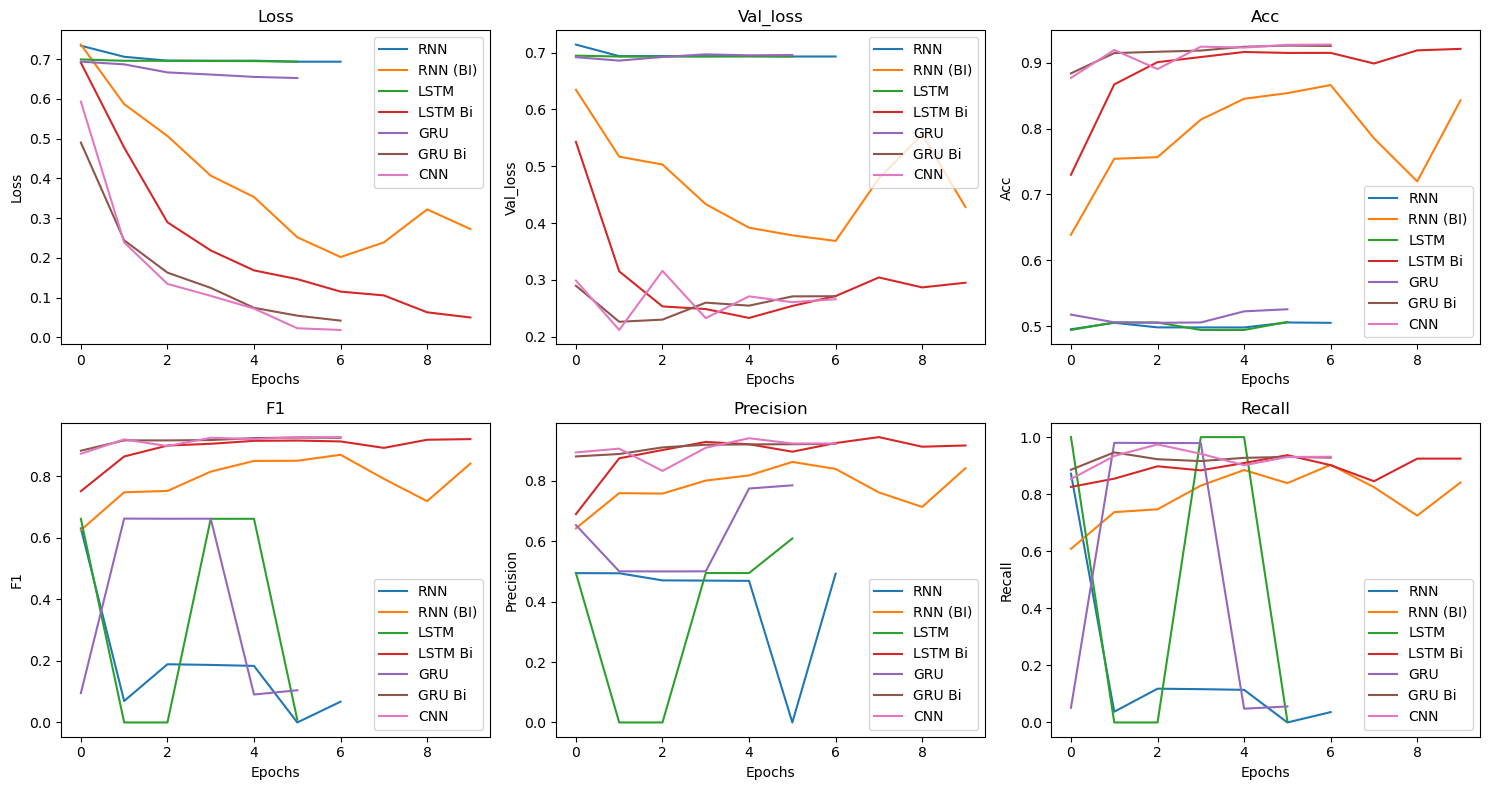

In [63]:
histories = {
    'RNN': history_rnn,
    'RNN (BI)': history_rnn_bi,
    'LSTM': history_lstm,
    'LSTM Bi': history_lstm_bi,
    'GRU': history_gru,
    'GRU Bi': history_gru_bi,
    'CNN': history_cnn
}

Utils.plot_training_history(histories)

- Confusion matrix

In [54]:
# Get predictions
y_pred_rnn, y_pred_rnn_bi, y_pred_lstm, y_pred_lstm_bi, y_pred_gru, y_pred_gru_bi, y_pred_cnn = model_rnn.predict(X_test), model_rnn_bi.predict(X_test), model_lstm.predict(X_test), model_lstm_bi.predict(X_test), model_gru.predict(X_test), model_gru_bi.predict(X_test), model_cnn.predict(X_test)

models_preds = {
        'RNN': y_pred_rnn,
        'RNN (BI)': y_pred_rnn_bi,
        'LSTM': y_pred_lstm,
        'LSTM (BI)': y_pred_lstm_bi,
        'GRU': y_pred_gru,
        'GRU (BI)': y_pred_gru_bi,
        'CNN': y_pred_cnn
}

Utils.plot_confusion_matrices(y_test, models_preds)

- Comaprison Table

In [62]:
models = {
    'RNN': model_rnn,
    'RNN (BI)': model_rnn_bi,
    'LSTM': model_lstm,
    'LSTM (BI)': model_lstm_bi,
    'GRU': model_gru,
    'GRU (BI)': model_gru_bi,
    'CNN': model_cnn
}

Utils.generate_comparison_table(histories,
                                models=models)

KeyError: 'GRU Bi'

# Summary

- RNN (BI):
    - Pros: Simple architecture, fast training time.
    - Cons: Limited context (low accuracy), prune to vanishing gradient problem.

- LSTM (BI):
    - Pros: Long-term dependencies, less prone to vanishing gradient problem.
    - Cons: Longer training time, more complex architecture.
- GRU (BI):
    - Pros: Simpler architecture than LSTM, faster training time.
    - Cons: Limited context, more parameters, prune to overfitting.
- CNN:
    - Pros: Best performance on this dataset, fast inference time.
    - Cons: May not generalize well to sequence data without significant tuning.

# Recommendation

- Based on the analysis, **LSTM** offers the best balance between performance and complexity for this task, especially if handling sequence data is a priority. For faster inference and a smaller model footprint, consider **CNN** with additional tuning. For simpler tasks, **RNN** or **GRU** may be sufficient.